[nltk_data] Downloading package stopwords to /Users/pedro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Successfully loaded data with 92 rows and 9 columns

Column names: ['id', 'dataset', 'question', 'ground_truth_answer', 'ground_truth_explanation', 'gemini_model', 'gemini_parsed_answer', 'gemini_raw_response', 'gemini_outcome']

First 3 rows:
                                     id  dataset  \
0  e9ad821a-c438-4965-9f77-760819dfa155  medmcqa   
1  e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3  medmcqa   
2  5c38bea6-787a-44a9-b2df-88f4218ab914  medmcqa   

                                            question ground_truth_answer  \
0  Chronic urethral obstruction due to benign pri...                   C   
1  Which vitamin is supplied from only animal sou...                   C   
2  All of the following are surgical options for ...                   D   

                            ground_truth_explanation             gemini_model  \
0  Chronic urethral obstruction because of urinar...  models/gemini-2.0-flash   
1  Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...  models/gemini-2.0-flash   

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/pedro/nltk_data'
    - '/Users/pedro/Desktop/SW-Generation-w-Tooling/.venv/nltk_data'
    - '/Users/pedro/Desktop/SW-Generation-w-Tooling/.venv/share/nltk_data'
    - '/Users/pedro/Desktop/SW-Generation-w-Tooling/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


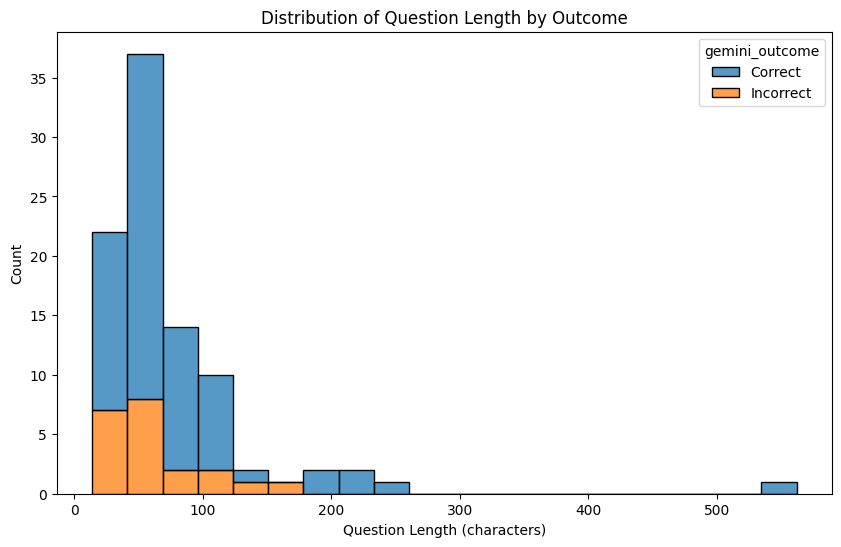

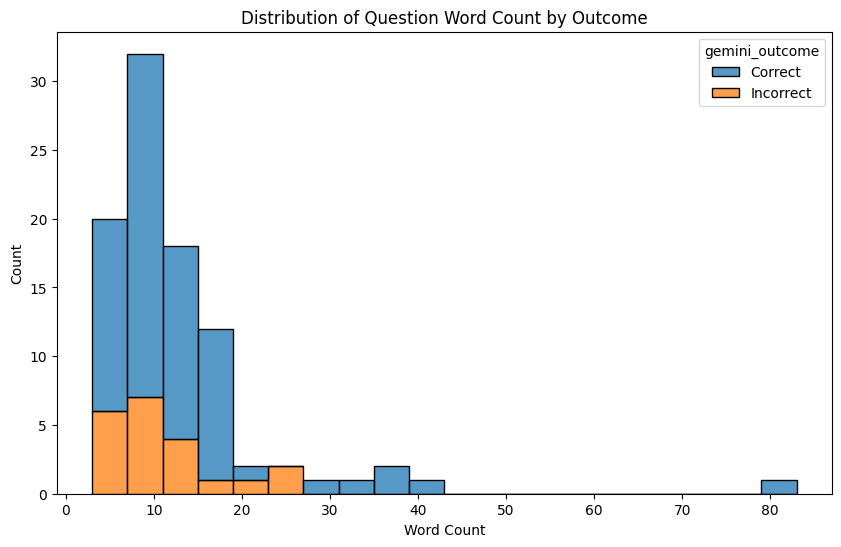

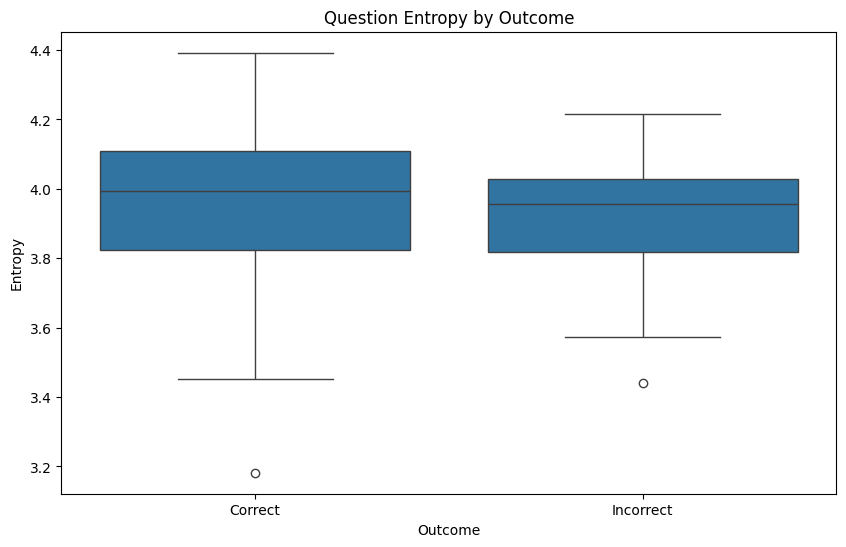

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Make sure necessary NLTK data is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load the data
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data with {len(df)} rows and {len(df.columns)} columns")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Calculate basic statistics
def basic_stats(df):
    total_questions = len(df)
    correct_answers = df[df['gemini_outcome'] == 'Correct'].shape[0]
    incorrect_answers = total_questions - correct_answers
    accuracy = correct_answers / total_questions * 100 if total_questions > 0 else 0
    
    print(f"Total questions: {total_questions}")
    print(f"Correct answers: {correct_answers}")
    print(f"Incorrect answers: {incorrect_answers}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    return {
        'total': total_questions,
        'correct': correct_answers,
        'incorrect': incorrect_answers,
        'accuracy': accuracy
    }

# Analyze question length
def analyze_question_length(df):
    df['question_length'] = df['question'].apply(len)
    df['question_word_count'] = df['question'].apply(lambda x: len(str(x).split()))
    
    # Group by outcome and calculate mean lengths
    length_by_outcome = df.groupby('gemini_outcome')['question_length'].mean()
    word_count_by_outcome = df.groupby('gemini_outcome')['question_word_count'].mean()
    
    print("\nAverage question length by outcome:")
    print(length_by_outcome)
    print("\nAverage word count by outcome:")
    print(word_count_by_outcome)
    
    # Plot histogram of question lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='question_length', hue='gemini_outcome', bins=20, multiple='stack')
    plt.title('Distribution of Question Length by Outcome')
    plt.xlabel('Question Length (characters)')
    plt.ylabel('Count')
    plt.savefig('question_length_distribution.png')
    
    # Plot histogram of word counts
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='question_word_count', hue='gemini_outcome', bins=20, multiple='stack')
    plt.title('Distribution of Question Word Count by Outcome')
    plt.xlabel('Word Count')
    plt.ylabel('Count')
    plt.savefig('question_word_count_distribution.png')
    
    return df

# Analyze question complexity using entropy
def calculate_entropy(text):
    if not text or not isinstance(text, str):
        return 0
    
    # Calculate frequency of each character
    counter = Counter(text.lower())
    frequencies = np.array(list(counter.values()))
    frequencies = frequencies / sum(frequencies)
    
    # Calculate entropy
    entropy = -np.sum(frequencies * np.log2(frequencies))
    return entropy

def analyze_complexity(df):
    df['question_entropy'] = df['question'].apply(calculate_entropy)
    
    # Group by outcome and calculate mean entropy
    entropy_by_outcome = df.groupby('gemini_outcome')['question_entropy'].mean()
    
    print("\nAverage question entropy by outcome:")
    print(entropy_by_outcome)
    
    # Plot entropy distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='gemini_outcome', y='question_entropy')
    plt.title('Question Entropy by Outcome')
    plt.xlabel('Outcome')
    plt.ylabel('Entropy')
    plt.savefig('question_entropy_by_outcome.png')
    
    return df

# Analyze topics using keywords
def analyze_topics(df):
    # Create a copy of the dataframe with just incorrect answers if any
    incorrect_df = df[df['gemini_outcome'] != 'Correct'] if 'Incorrect' in df['gemini_outcome'].values else pd.DataFrame()
    correct_df = df[df['gemini_outcome'] == 'Correct']
    
    if len(incorrect_df) == 0:
        print("\nNo incorrect answers found for topic analysis.")
        return None
    
    # Function to extract key medical terms
    def extract_keywords(text):
        if not isinstance(text, str):
            return []
        
        # Tokenize and remove stopwords
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text.lower())
        keywords = [word for word in words if word.isalpha() and word not in stop_words]
        
        return keywords
    
    # Extract keywords from questions
    incorrect_keywords = []
    for question in incorrect_df['question']:
        incorrect_keywords.extend(extract_keywords(question))
    
    correct_keywords = []
    for question in correct_df['question']:
        correct_keywords.extend(extract_keywords(question))
    
    # Count keyword frequencies
    incorrect_counter = Counter(incorrect_keywords)
    correct_counter = Counter(correct_keywords)
    
    # Normalize counts by total questions in each category
    for word in incorrect_counter:
        incorrect_counter[word] /= len(incorrect_df)
    
    for word in correct_counter:
        correct_counter[word] /= len(correct_df)
    
    # Find words that are more common in incorrect questions
    differential_words = {}
    for word in incorrect_counter:
        if word in correct_counter:
            differential_words[word] = incorrect_counter[word] - correct_counter[word]
        else:
            differential_words[word] = incorrect_counter[word]
    
    # Sort by differential frequency
    sorted_words = sorted(differential_words.items(), key=lambda x: x[1], reverse=True)
    
    print("\nTop keywords more common in questions the model got wrong:")
    for word, diff in sorted_words[:20]:
        print(f"{word}: {diff:.4f}")
    
    # Plot top differentiating keywords
    plt.figure(figsize=(12, 8))
    words = [word for word, _ in sorted_words[:15]]
    diffs = [diff for _, diff in sorted_words[:15]]
    
    plt.bar(words, diffs)
    plt.title('Keywords More Common in Incorrectly Answered Questions')
    plt.xlabel('Keyword')
    plt.ylabel('Differential Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('differentiating_keywords.png')
    
    return sorted_words

# Analyze answer distributions
def analyze_answers(df):
    # Count occurrences of each answer option
    answer_counts = df['ground_truth_answer'].value_counts()
    correct_answer_counts = df[df['gemini_outcome'] == 'Correct']['ground_truth_answer'].value_counts()
    
    # Calculate accuracy by answer option
    accuracy_by_answer = {}
    for answer in answer_counts.index:
        total = answer_counts[answer]
        correct = correct_answer_counts.get(answer, 0)
        accuracy_by_answer[answer] = (correct / total * 100) if total > 0 else 0
    
    print("\nDistribution of ground truth answers:")
    print(answer_counts)
    
    print("\nAccuracy by answer option:")
    for answer, accuracy in accuracy_by_answer.items():
        print(f"{answer}: {accuracy:.2f}%")
    
    # Plot answer distribution
    plt.figure(figsize=(10, 6))
    answer_counts.plot(kind='bar')
    plt.title('Distribution of Ground Truth Answers')
    plt.xlabel('Answer Option')
    plt.ylabel('Count')
    plt.savefig('answer_distribution.png')
    
    # Plot accuracy by answer
    plt.figure(figsize=(10, 6))
    plt.bar(accuracy_by_answer.keys(), accuracy_by_answer.values())
    plt.title('Accuracy by Answer Option')
    plt.xlabel('Answer Option')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.savefig('accuracy_by_answer.png')
    
    return accuracy_by_answer

# Check if questions include special formatting
def analyze_formatting(df):
    def has_special_formatting(text):
        if not isinstance(text, str):
            return False
        
        # Check for various formatting elements
        has_numbers = bool(re.search(r'\d+', text))
        has_special_chars = bool(re.search(r'[^\w\s]', text))
        has_uppercase = bool(re.search(r'[A-Z]', text))
        has_abbreviation = bool(re.search(r'\b[A-Z]{2,}\b', text))
        
        return {
            'numbers': has_numbers,
            'special_chars': has_special_chars,
            'uppercase': has_uppercase,
            'abbreviation': has_abbreviation
        }
    
    # Apply the function to each question
    formatting_results = df['question'].apply(has_special_formatting)
    
    # Extract results
    df['has_numbers'] = formatting_results.apply(lambda x: x['numbers'])
    df['has_special_chars'] = formatting_results.apply(lambda x: x['special_chars'])
    df['has_uppercase'] = formatting_results.apply(lambda x: x['uppercase'])
    df['has_abbreviation'] = formatting_results.apply(lambda x: x['abbreviation'])
    
    # Calculate accuracy for each formatting type
    formatting_cols = ['has_numbers', 'has_special_chars', 'has_uppercase', 'has_abbreviation']
    
    print("\nAccuracy by question formatting:")
    for col in formatting_cols:
        # Questions with this formatting
        with_formatting = df[df[col] == True]
        if len(with_formatting) == 0:
            accuracy_with = 0
        else:
            accuracy_with = (with_formatting['gemini_outcome'] == 'Correct').mean() * 100
            
        # Questions without this formatting
        without_formatting = df[df[col] == False]
        if len(without_formatting) == 0:
            accuracy_without = 0
        else:
            accuracy_without = (without_formatting['gemini_outcome'] == 'Correct').mean() * 100
            
        print(f"{col.replace('has_', '')}: With: {accuracy_with:.2f}%, Without: {accuracy_without:.2f}%")
    
    # Plot formatting impact
    plt.figure(figsize=(12, 8))
    
    # Prepare data for grouped bar chart
    categories = [col.replace('has_', '') for col in formatting_cols]
    accuracy_with = []
    accuracy_without = []
    
    for col in formatting_cols:
        with_formatting = df[df[col] == True]
        without_formatting = df[df[col] == False]
        
        if len(with_formatting) == 0:
            accuracy_with.append(0)
        else:
            accuracy_with.append((with_formatting['gemini_outcome'] == 'Correct').mean() * 100)
            
        if len(without_formatting) == 0:
            accuracy_without.append(0)
        else:
            accuracy_without.append((without_formatting['gemini_outcome'] == 'Correct').mean() * 100)
    
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, accuracy_with, width, label='With')
    ax.bar(x + width/2, accuracy_without, width, label='Without')
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Accuracy by Question Formatting')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('formatting_impact.png')
    
    return df

# Main analysis function
def analyze_medical_qa_data(file_path):
    # Load data
    df = load_data(file_path)
    if df is None:
        return
    
    # Print column names and first few rows
    print("\nColumn names:", df.columns.tolist())
    print("\nFirst 3 rows:")
    print(df.head(3))
    
    # Basic statistics
    stats = basic_stats(df)
    
    # Question length analysis
    df = analyze_question_length(df)
    
    # Question complexity analysis
    df = analyze_complexity(df)
    
    # Topic analysis
    topic_words = analyze_topics(df)
    
    # Answer distribution analysis
    answer_stats = analyze_answers(df)
    
    # Formatting analysis
    df = analyze_formatting(df)
    
    # Check for correlation between features
    numeric_cols = ['question_length', 'question_word_count', 'question_entropy']
    correlation = df[numeric_cols].corr()
    print("\nCorrelation between features:")
    print(correlation)
    
    # Generate a correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation')
    plt.tight_layout()
    plt.savefig('feature_correlation.png')
    
    print("\nAnalysis complete! Visualizations saved as PNG files.")
    
    return df

# Execute the analysis (uncomment when ready to run)
if __name__ == "__main__":
    file_path = "./results_2025-04-22_23-00-05/gemini_results_medmcqa.csv"
    analyzed_df = analyze_medical_qa_data(file_path)

